# Data simulation

In [1]:
import numpy as np
import pylab as pl
import orb.sim
import orb.utils.spectrum
import orb.cube
from importlib import reload

## source spectrum simulation

The simulator needs an input source spectrum in erg/cm2/s/A. If you already have one you don't have to create it. If you don't, you can use ORB objects to do it. It is also a nice way to understand how it works under the hood.

(645, 685)

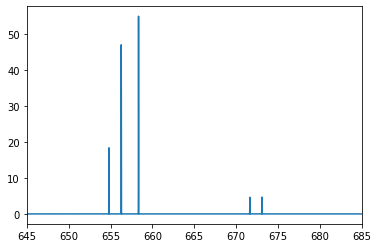

In [2]:
# simulate an hii region
axis = np.linspace(600, 750, 30000) # a high resolution spectrum is needed 
fwhm = 0.02
hii_spectrum = np.zeros_like(axis)
lines = orb.core.Lines().get_line_nm(['Halpha', '[NII]6548', '[NII]6584', '[SII]6717', '[SII]6731'])
fluxes = [1, 1.2/3., 1.2, 0.1, 0.1]
for iline, iflux in zip(lines, fluxes):
    iline = orb.utils.spectrum.gaussian1d(axis, 0, 1, iline, fwhm)
    iline /= orb.utils.spectrum.gaussian1d_flux(1, fwhm) / iflux
    hii_spectrum += iline

hii_spectrum = orb.core.Vector1d(hii_spectrum, axis=axis)
hii_spectrum.plot()
pl.xlim((645,685))

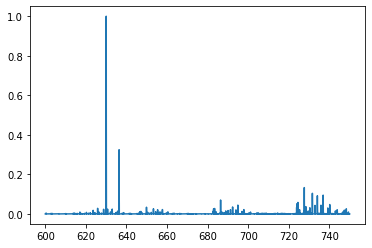

In [3]:
# simulate the sky lines
sky_spectrum = np.zeros_like(hii_spectrum.axis.data)
sky_lines = orb.core.Lines().air_sky_lines_nm
for iline in sky_lines:
    
    iline_nm = sky_lines[iline][0]
    iline_amp = sky_lines[iline][1]
    if ((hii_spectrum.axis[0] < iline_nm)
        and(hii_spectrum.axis[-1] > iline_nm)):
        
        sky_spectrum += orb.utils.spectrum.gaussian1d(axis, 0, iline_amp, iline_nm, 0.05)

sky_spectrum /= np.max(sky_spectrum)
sky_spectrum = orb.core.Vector1d(sky_spectrum, axis=axis)
sky_spectrum.plot()

In [4]:
# create the final spectrum in erg/cm2/s/A
source_spectrum = (sky_spectrum.data + hii_spectrum.data) * .5e-17 + 0.e-15 

## simulate an interferogram

In [5]:
# define the observation parameters
params = {
    'instrument': 'sitelle', # instrument name
    'filter_name': 'SN3', # can be any SITELLE filters: SN1, SN2, SN3, C1, C2, C3, C4
    'exposure_time': 15, # exposure time in s (for 1 step)
    'step_nb': 593, # number of steps
    'airmass': 1, # target airmass, set it to 0 and you are in space ;)
}

/home/thomas/Astro/Python/ORB/Orb/orb/sim.py:227: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum.data.astype(float),
/home/thomas/Astro/Python/ORB/Orb/orb/fft.py:717: ComplexWarning: Casting complex values to real discards the imaginary part
  interf.data += np.mean(spec.data).astype(np.float128) / 2.


Text(0.5, 1.0, 'simulated interferogram')

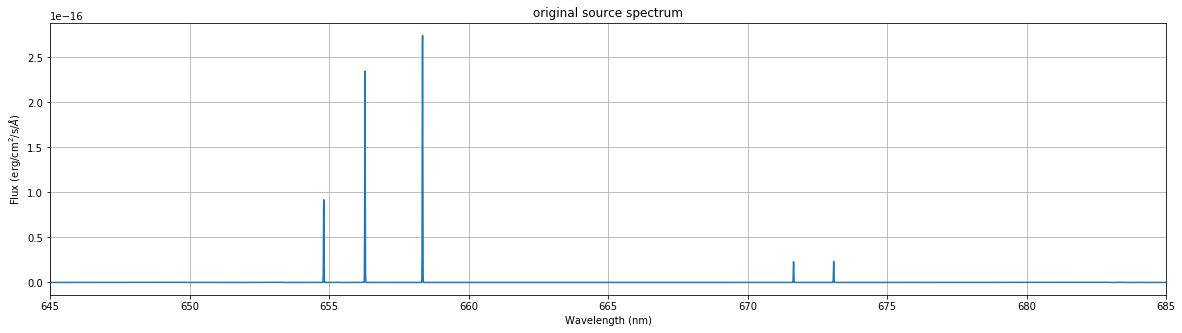

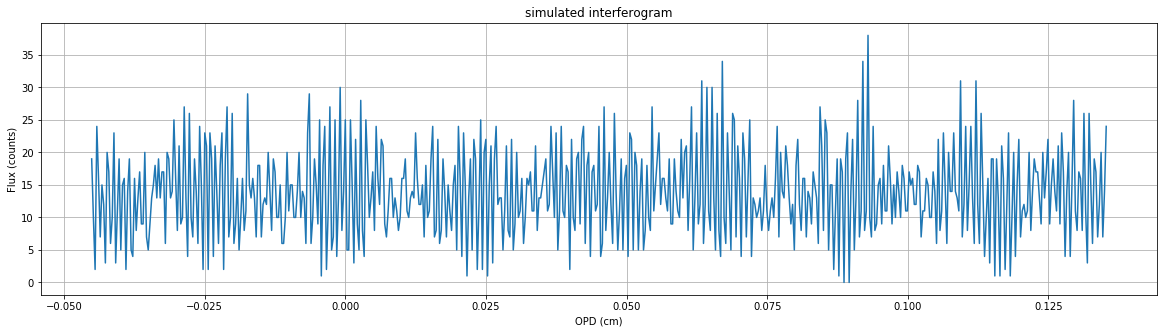

In [6]:
# instantiate a SourceSpectrum object which is the simulation class
reload(orb.sim)
source_spectrum = orb.sim.SourceSpectrum(source_spectrum, axis, params)

pl.figure(figsize=(20,5))
source_spectrum.plot()
pl.xlabel('Wavelength (nm)')
pl.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)')
pl.xlim((645,685))
#pl.ylim((0,1.5e-16))
pl.grid()
pl.title('original source spectrum')

# simulate an interferogram
interf = source_spectrum.get_interferogram(theta=15)

pl.figure(figsize=(20,5))
interf.plot()
pl.xlabel('OPD (cm)')
pl.ylabel('Flux (counts)')
pl.grid()
pl.title('simulated interferogram')


## generate the uncalibrated observed spectrum 

/home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Uncalibrated simulated spectrum')

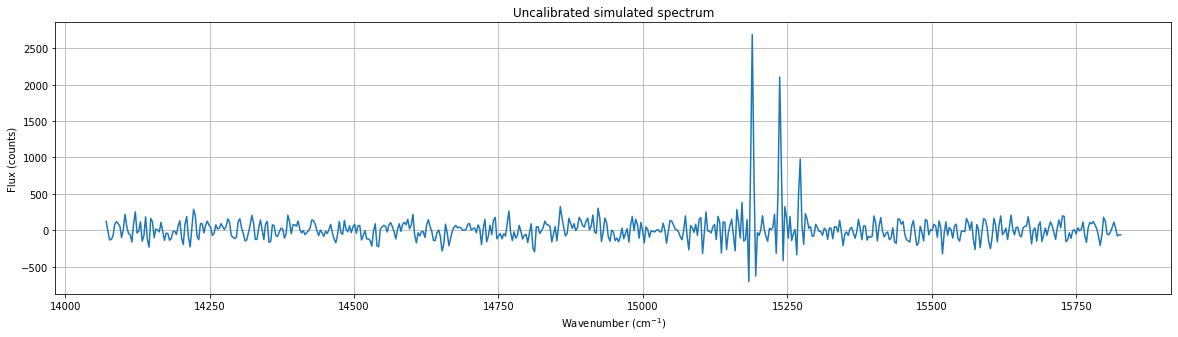

In [7]:
observed_spectrum = interf.get_spectrum()

pl.figure(figsize=(20,5))
observed_spectrum.plot()
pl.xlabel(r'Wavenumber (cm$^{-1}$)')
pl.ylabel('Flux (counts)')
pl.grid()
pl.title('Uncalibrated simulated spectrum')

## calibrate the observed spectrum

/home/thomas/Astro/Python/ORB/Orb/orb/core.py:2498: RuntimeWarning: divide by zero encountered in power
  _out = getattr(np, opname)(_out, _arg)


Text(0.5, 1.0, 'Calibrated simulated spectrum')

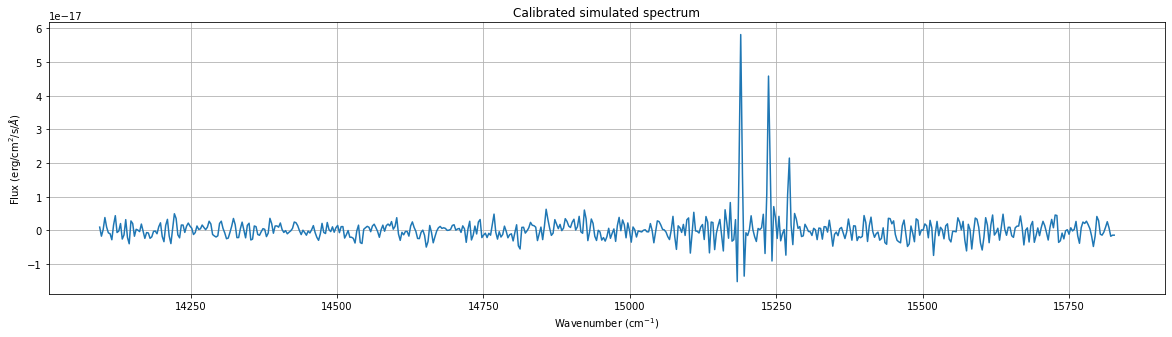

In [8]:
# compute the calibration function
photom = orb.photometry.Photometry(params['filter_name'], 0, airmass=params['airmass'])
calibrated_spectrum = observed_spectrum.copy()
flambda = photom.compute_flambda(modulated=True)
# apply the calibration (spectrum must be converted to counts/s)
calibrated_spectrum.data /= params['step_nb'] * params['exposure_time']
calibrated_spectrum = calibrated_spectrum.math('multiply', flambda)


pl.figure(figsize=(20,5))
calibrated_spectrum.plot()

#flambda.plot()
pl.xlabel(r'Wavenumber (cm$^{-1}$)')
pl.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)')
pl.grid()
pl.title('Calibrated simulated spectrum')

## fit the calibrated spectrum

The fitting procedure implies a lot of parameters. They are all defined in the documentation of ORCS (https://orcs.readthedocs.io/en/latest/index.html) which is the fitting engine for SITELLE cubes. To fit only one spectrum, we can use the spectrum fitting method directly.

/home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fluxes [7.73(34)e-17 9.89(34)e-17 3.47(33)e-17 4.5(3.5)e-18 1.07(35)e-17]
velocities [7.25977727 7.25977727 7.25977727 7.25977727 7.25977727]


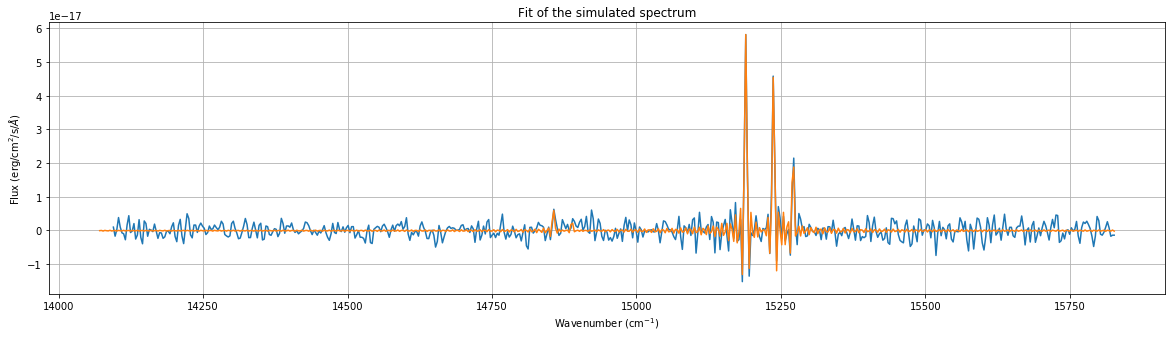

In [9]:
fit = calibrated_spectrum.fit(('Halpha', '[NII]6584', '[NII]6548', '[SII]6717', '[SII]6731'), 
                              fmodel='sinc',
                              pos_def=('1','1','1','1','1'))
pl.figure(figsize=(20,5))
calibrated_spectrum.plot()
pl.plot(calibrated_spectrum.axis.data, fit['fitted_vector'])
pl.xlabel(r'Wavenumber (cm$^{-1}$)')
pl.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)')
pl.grid()
pl.title('Fit of the simulated spectrum')
print('fluxes', fit['flux_gvar'])
print('velocities', fit['velocity_gvar'])

## comparison with real data

We can compare the obtained spectrum with the real data we tried to simulate. The only difference is the velocity of the lines which came from an error on the preliminary velocity calibration of the real data.

/home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fluxes [6.92(25)e-17 9.78(25)e-17 3.16(25)e-17 2.8(2.6)e-18 9.7(2.7)e-18]
velocities [67.26521425 67.26521425 67.26521425 67.26521425 67.26521425]


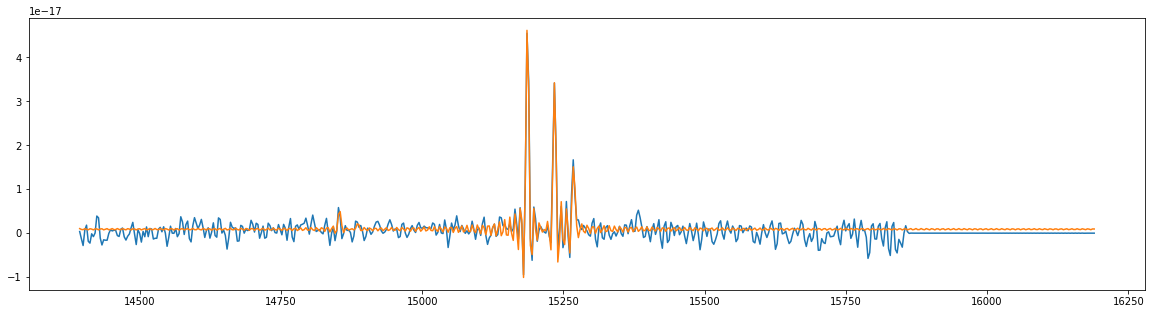

In [10]:
m57_spec = orb.fft.Spectrum('m57_spectrum0.hdf5')
m57_fit = m57_spec.fit(('Halpha', '[NII]6584', '[NII]6548', '[SII]6717', '[SII]6731'), 
                              fmodel='sinc', 
                              pos_def=('1','1','1','1','1'))
pl.figure(figsize=(20,5))
m57_spec.plot()
pl.plot(m57_spec.axis.data, m57_fit['fitted_vector'])
print('fluxes', m57_fit['flux_gvar'])
print('velocities', m57_fit['velocity_gvar'])